In [1]:
#| hide
import datasets
datasets.logging.set_verbosity(datasets.logging.WARNING)

# Paper - Code Analysis Results

> Paper results for the performance of code models on different code constructs!

In [2]:
#|eval: false
from code_tokenizers.core import CodeTokenizer
from transformers import AutoModelForCausalLM

model_name = "bigcode/santacoder"
py_tokenizer = CodeTokenizer.from_pretrained(model_name, "python", padding_token="<|endoftext|>")
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
py_tokenizer.tokenizer

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


PreTrainedTokenizerFast(name_or_path='bigcode/santacoder', vocab_size=49152, model_max_len=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<fim-prefix>', '<fim-middle>', '<fim-suffix>', '<fim-pad>']})

In [ ]:
#| hide
!pip install -U git+https://github.com/ncoop57/code_tokenizers.git
!download_grammars

## Dataset Preparation

In order to construct our dataset, we used the GPL 3.0 version of the [codeparrot/github-code]() dataset as the models we are evaluating explicitly remove GPL licensed code, so there is a less chance of data leakage. Additionally, we filter out code that goes beyond 4096 characters long as the AST parser we use can be slow for very long code snippets. We also filter out code that is not written in Python, as we are only evaluating Python code models.

In [3]:
from datasets import load_dataset

ds = load_dataset(
  "codeparrot/github-code",
  split="train",
  streaming=False,
  languages=["Python"],
  licenses=["gpl-3.0"],
).select(range(5_000))
filtered_ds = ds.filter(lambda example: len(example["code"]) < 4096)
len(filtered_ds)

Using custom data configuration Python-gpl-3.0-28cc4ef0856c1926
Found cached dataset github-code (/transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae)
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-9dd4ab69562c7be7.arrow


2920

Next we filter out repositories that do not have multiple files in the dataset as we are primarly concerned with internal vs. external method call prediction performance. We then extract all the method definitions and invocations and filter out any examples that do not have internal method invocations. Will also filter out internal methods that are very common such as get and set. Lastly, we ensure there is an even representation of internal and external method calls in the dataset.

In [4]:
def find_duplicates(items):
  # Create an empty set to store the items that we have already seen
  seen = set()

  # Create an empty list to store the duplicates that we find
  duplicates = []

  # Loop through each item in the list
  for item in items:
    # If the item is already in the "seen" set, then it must be a duplicate
    if item in seen:
      # Add the duplicate to the list
      duplicates.append(item)
    # If the item is not in the "seen" set, then add it to the set
    else:
      seen.add(item)

  # Return the list of duplicates
  return duplicates

repo_names = find_duplicates(filtered_ds["repo_name"])

repo_files = {}
for repo_name in repo_names:
    rows_w_repo = filtered_ds.filter(
      lambda example: example["repo_name"] == repo_name
    )

    if len(rows_w_repo) > 1:
        repo_files[repo_name] = [row["code"] for row in rows_w_repo]
        if len(repo_files) > 400:
            break

# filter out repos with only one file
filtered_ds = filtered_ds.filter(lambda example: example["repo_name"] in repo_files)
len(filtered_ds)

Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-391f69df686a0ad6.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-ee62f2e7edffdd2e.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-658b1321dbd692dc.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-2a2ca066264424d7.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c73

767

In [5]:
#|eval: false
from code_tokenizers.core import CodeTokenizer
from transformers import AutoModelForCausalLM

model_name = "bigcode/santacoder"
py_tokenizer = CodeTokenizer.from_pretrained(model_name, "python", padding_token="<|endoftext|>")
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
py_tokenizer.tokenizer

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


PreTrainedTokenizerFast(name_or_path='bigcode/santacoder', vocab_size=49152, model_max_len=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<fim-prefix>', '<fim-middle>', '<fim-suffix>', '<fim-pad>']})

In [6]:
#|eval: false
from code_tokenizers.helpers import get_internal_methods

# add the internal methods to the dataset
filtered_ds = filtered_ds.map(
    lambda example: {
        "internal_methods": get_internal_methods(
            repo_files[example["repo_name"]],
            py_tokenizer
        )
    }
)
# filter out repos with no internal methods
filtered_ds = filtered_ds.filter(lambda example: len(example["internal_methods"]) > 0)
len(filtered_ds)

Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-342f51ed5d25da3f.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-c23fae6e64126b1d.arrow


695

In [7]:
#|eval: false
from functools import partial
from transformers import default_data_collator

def code_collator(batch):
    merged_ast = []
    for b in batch:
        merged_ast.append(b.pop("merged_ast"))
    batch = default_data_collator(batch)
    batch["merged_ast"] = merged_ast
    return batch

def tokenizer_wrapper(tokenizer, example, column, *args, **kwargs):
    return tokenizer(example[column], internal_methods=example["internal_methods"], *args, **kwargs)

# Setup tokenizer
tokenizer = partial(tokenizer_wrapper, py_tokenizer, column="code")
tokenizer.decode = py_tokenizer.decode
tokenizer.pad_token = py_tokenizer.tokenizer.pad_token

In [8]:
#|eval: false
from perplexed.core import perplexed

device = "cuda"
model = model.to(device)
cross_dist, token_cnt = perplexed(
    model,
    filtered_ds,
    tokenizer=tokenizer,
    column="code",
    semantic_column="merged_ast",
    batch_size=32,
    num_proc=64,
    device=device,
    collate_fn=code_collator,
    pass_row=True,
    return_tokens=True,
    return_distributions=True,
    compute_perplexity=False,
)

Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-bf95ebbdc1a2da8a.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-1b9fbc61ebfe228f.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-399c72030286f9c7.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-73cca7cb0013eda2.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-3786d793ea5c7fa9.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-35179f311d5aff07.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-419e95c5293eceec.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-da58dde29d08908e.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-f5d577ed05c1a48c.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-30a768f76ba4fbb9.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-fe419254188e4dd5.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-332d5004c2c6dd95.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-8033222c50601fb5.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-ab4e444a55251114.arrow
Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-089819d20d48d14b.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-40e3d611cfa880a3.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-72e5b5719a2df856.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-42581efcec480758.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-0765fc3c8a3a418e.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-86286fa1f8e74b3f.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-e2606f98c6174f30.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-be3af6fcf44ec3e4.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-74ef9f230ac439d9.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-71d9c7299da47d2a.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-47b5467629b1f470.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-29319c43cd7c30d9.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-b94a07e0864587f1.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-025da386ad1a7ea9.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-718b7e0679004054.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-e6283c0ed1efb42d.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-b3cda530f894e839.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-da6938e7c349cfef.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-edda71ecefeb8358.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-6f3ab6d3516e2138.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-bf8e959e1dd2ea38.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-8aee450f5f9bfdac.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-0ee9a98b7b8f5021.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-aae3b11c35d919d9.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-123e7f782dad4651.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-e36d396c9d5097b7.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-a10e0599a594760f.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-587c08a48865c69c.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-113be613fa918cf4.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-2ef38d3968db7189.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-950d40bbbf6b3348.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-5815ec8ee39caffb.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-ca0c2577d76fb308.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-df08742e9d2fa083.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-71af6b4ebd9fbbcf.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-57a06c618b8d7db1.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-3de94b124585f66e.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-a5fff8344e2fdc91.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-bddf8e4e1ad44112.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-1bceb3ec8215f97b.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-2d32d7d8fc3f0f05.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-9ee3d5e96472a52a.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-fc3e8a22adaf5e47.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-112b7ce5e3092e81.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-b154947acd401d63.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-1b555473145e44ad.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-9341a1439ee43bf0.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-28e3a49ddb5c6977.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-b2e4839556b24b92.arrow


Loading cached processed dataset at /transformers_cache/codeparrot___github-code/Python-gpl-3.0-28cc4ef0856c1926/1.0.0/707f9a29dc25137d4e27b954d3c7304afa607f0d51b1fa5ef526e8dc51beeaae/cache-7b0670857b569abb.arrow


Output()

In [9]:
most_common = token_cnt.most_common()

In [11]:
# most_common = token_cnt.most_common(2_000)
# filter out that don't start with a < and end with a >
argument_lists = [t for t in most_common if t[0].startswith("<argument_list") or t[0].startswith("<call")] # [:10]

In [12]:
argument_lists

[('<argument_list -> string>', 10994),
 ('<argument_list -> (>', 8039),
 ('<argument_list -> identifier>', 4947),
 ('<argument_list -> )>', 4023),
 ('<call -> identifier>', 4006),
 ('<argument_list -> ,>', 2255),
 ('<call -> identifier (internal)>', 1362),
 ('<argument_list -> identifier (internal)>', 1029),
 ('<argument_list -> integer>', 891),
 ('<argument_list -> string (internal)>', 640),
 ('<argument_list -> ( (internal)>', 450),
 ('<argument_list -> float>', 294),
 ('<argument_list -> ) (internal)>', 266),
 ('<argument_list -> , (internal)>', 240),
 ('<argument_list -> integer (internal)>', 118),
 ('<argument_list -> float (internal)>', 95),
 ('<argument_list -> comment>', 57),
 ('<argument_list -> true>', 39),
 ('<argument_list -> none>', 38),
 ('<argument_list -> false>', 22),
 ('<argument_list -> true (internal)>', 1),
 ('<argument_list -> false (internal)>', 1),
 ('<argument_list -> none (internal)>', 1)]

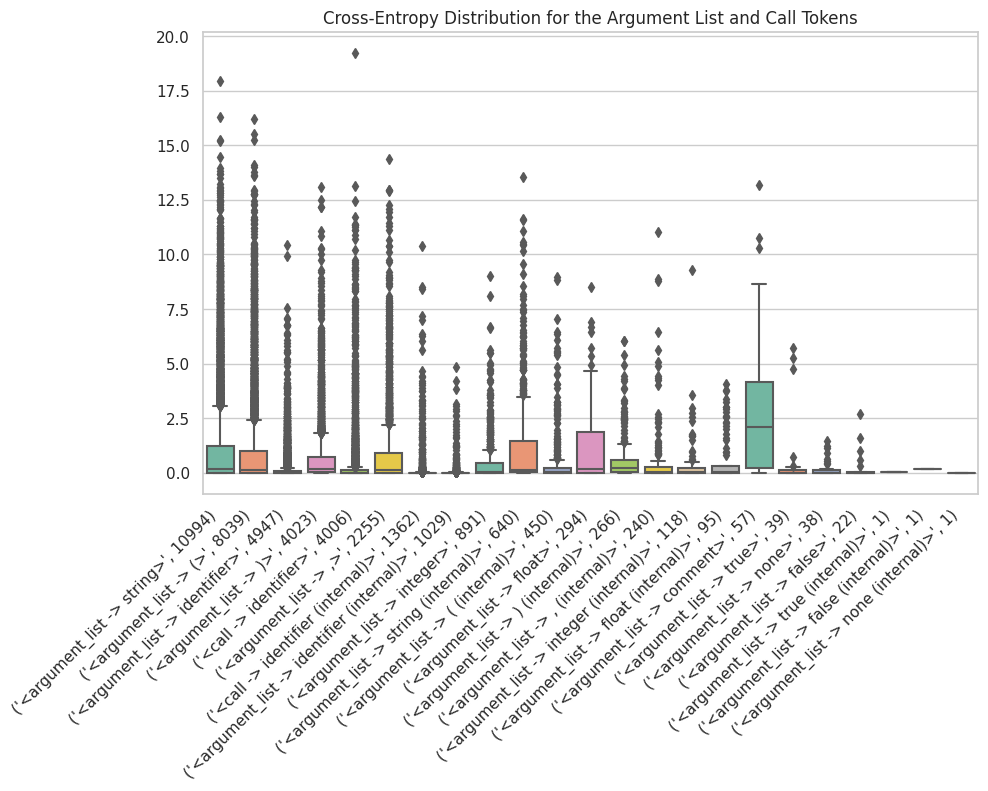

In [13]:
#|eval: false
# boxplot the distribution of perplexities for the most common tokens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

# most_common = token_cnt.most_common(15)
argument_lists_tokens = [token for token, _ in argument_lists]
argument_lists_crosses = [
    cross_dist[token]
    for token in argument_lists_tokens
]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=argument_lists_crosses, palette="Set2")
ax.set_xticklabels(argument_lists)
ax.set_title("Cross-Entropy Distribution for the Argument List and Call Tokens")
plt.xticks(rotation=45, ha="right")
plt.show()

In [39]:
plt.savefig("internal_vs_external.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.clf()

In [40]:
# filter out that don't start with a < and end with a >
most_common = [t for t in most_common if "->" in t[0] and "ERROR" not in t[0]][:10]

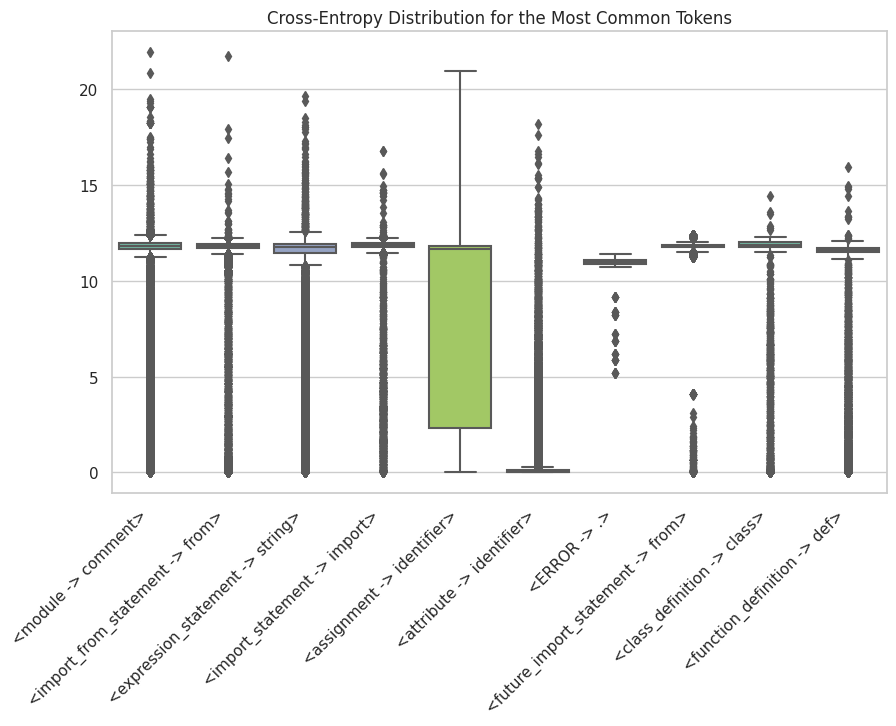

In [42]:
#|eval: false
# boxplot the distribution of perplexities for the most common tokens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

# most_common = token_cnt.most_common(15)
most_common_tokens = [token for token, _ in most_common]
most_common_perplexities = [
    cross_dist[token]
    for token in most_common_tokens
]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=most_common_perplexities, palette="Set2")
ax.set_xticklabels(most_common_tokens)
ax.set_title("Cross-Entropy Distribution for the Most Common Tokens")
plt.xticks(rotation=45, ha="right")
plt.show()

In [43]:
plt.savefig("most_common.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()